# Using a pretrained model to classify images

To achieve higher accuracy in image classification tasks, we can use a pretrained model. A pretrained model is a model that has been trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. We can use the pretrained model as a feature extractor, and then train a classifier on top of it. 

This is called **transfer learning**.

In this example, the pretrained model is InceptionV3, which is a model trained on the ImageNet dataset to classify images into 1000 classes. InceptionV3 is used as a feature extractor, feeding into a binary classifier for horses and humans.

This is achieved by:
- using `tensorflow.keras.applications.inception_v3.InceptionV3` without its top layer
- using `pre_trained_model.load_weights` to load the pretrained weights from a file
- preprocessing the output of the pretrained model (see the "Prepare the pre-trained model to accept the new data" section)
- flattening the output of the pretrained model and attaching a binary classifier on top of it

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [37]:
training_dir = 'data/horse-or-human/training'
validation_dir = 'data/horse-or-human/validation'
weights_file = 'inception_v3.h5'

In [38]:
# Download the weights
import urllib.request

weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7fc846e659c0>)

In [39]:
# Training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [40]:
# Validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


In [41]:
# Load the pre-trained model
pre_trained_model = InceptionV3(input_shape=(300, 300, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(weights_file)

In [42]:
# Show pre-trained model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 149, 149, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                      

In [43]:
# Prepare the pre-trained model to accept the new data

# Freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get the last layer (we specifically want the mixed7 layer)
last_layer = pre_trained_model.get_layer('mixed7')

# Get the output from the last layer
output_layer = last_layer.output


In [44]:
# Build the model, compile it and train it

# Flatten the output layer to 1 dimension
output_layer = layers.Flatten()(output_layer)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
output_layer = layers.Dense(1024, activation='relu')(output_layer)

# Add a final sigmoid layer for classification
output_layer = layers.Dense(1, activation='sigmoid')(output_layer)

# Create the model
model = Model(pre_trained_model.input, output_layer)

model.compile(
  optimizer=RMSprop(lr=0.0001),
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# Train the model
history = model.fit_generator(
    train_generator,
    epochs=15,  
    validation_data=validation_generator,
    verbose=1
)

/var/folders/yq/6hjjmqgj63s0mxztlhxls6r80000gn/T/ipykernel_34720/3027536931.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
9/9 [==============================] - 130s 14s/step - loss: 3.0430 - accuracy: 0.6738 - val_loss: 0.9412 - val_accuracy: 0.7500
Epoch 2/15
9/9 [==============================] - 129s 14s/step - loss: 0.0393 - accuracy: 0.9805 - val_loss: 0.8784 - val_accuracy: 0.7500
Epoch 3/15
9/9 [==============================] - 140s 15s/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 0.3510 - val_accuracy: 0.8711
Epoch 4/15
9/9 [==============================] - 146s 16s/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.5515 - val_accuracy: 0.8125
Epoch 5/15
9/9 [==============================] - 155s 17s/step - loss: 0.0312 - accuracy: 0.9893 - val_loss: 0.0441 - val_accuracy: 0.9883
Epoch 6/15
9/9 [==============================] - 156s 17s/step - loss: 0.5334 - accuracy: 0.8841 - val_loss: 0.6434 - val_accuracy: 0.8516
Epoch 7/15
9/9 [==============================] - 158s 17s/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.5003 - val_accuracy: 0.8672
Epoch 8/15
9/9 [====

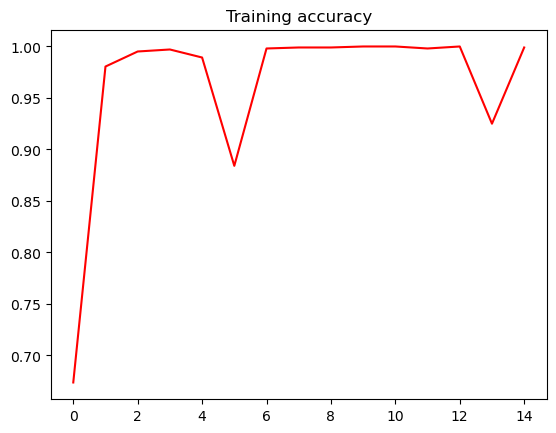

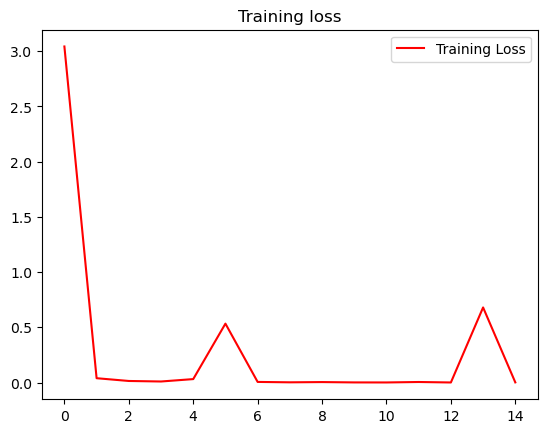

In [45]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()
